# Modèle de classement des textos en spam

Dans ce cas pratique on cherche à entraîner un modèle capable de prédire si un texto est un spam ou non. On s'appuie pour cela sur une base de données contenant des sms labellisés comme spam ou non spam (trouvée sur https://archive.ics.uci.edu/ml/datasets.php, voir readme pour plus d'informations).  

- Importez la base de données dans un dataframe 

In [1]:
import pickle


import numpy as np
import pandas as pd
#from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_gradient_magnitude

from wordcloud import WordCloud, ImageColorGenerator

In [2]:
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = os.path.dirname(__file__) if "__file__" in locals() else os.getcwd()

In [3]:
# load wikipedia text on rainbow
text = open(os.path.join(d, 'smsspamcollection/SMSSpamCollection.txt')).read()
text

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\nham\tOk lar... Joking wif u oni...\nspam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C\'s apply 08452810075over18\'s\nham\tU dun say so early hor... U c already then say...\nham\tNah I don\'t think he goes to usf, he lives around here though\nspam\tFreeMsg Hey there darling it\'s been 3 week\'s now and no word back! I\'d like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv\nham\tEven my brother is not like to speak with me. They treat me like aids patent.\nham\tAs per your request \'Melle Melle (Oru Minnaminunginte Nurungu Vettam)\' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune\nspam\tWINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. V

In [5]:
data = pd.read_csv(os.path.join(d, 'smsspamcollection/SMSSpamCollection.txt'), sep = "\t", header= None )

data

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
data = pd.read_csv("smsspamcollection/SMSSpamCollection.txt", sep = "\t", header= None )

data

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [6]:
data.columns = ['labels', 'texte']

In [7]:
data

,labels,texte
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


- Appliquez les transformations usuelles du texte pour faciliter l'analyse textuelle

In [8]:
text = text.lower() # passage en minuscules
text

'ham\tgo until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...\nham\tok lar... joking wif u oni...\nspam\tfree entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c\'s apply 08452810075over18\'s\nham\tu dun say so early hor... u c already then say...\nham\tnah i don\'t think he goes to usf, he lives around here though\nspam\tfreemsg hey there darling it\'s been 3 week\'s now and no word back! i\'d like some fun you up for it still? tb ok! xxx std chgs to send, £1.50 to rcv\nham\teven my brother is not like to speak with me. they treat me like aids patent.\nham\tas per your request \'melle melle (oru minnaminunginte nurungu vettam)\' has been set as your callertune for all callers. press *9 to copy your friends callertune\nspam\twinner!! as a valued network customer you have been selected to receivea £900 prize reward! to claim call 09061701461. claim code kl341. v

In [9]:
import re
import string

# On définit une fonction qui fait tout ça pour directement l'appliquer aux hommes et aux femmes : 
def premier_nettoyage(text):
    text = text.lower() # passage en minuscules
    #text = re.sub("\([0-9][0-9]e\)", "", text) # On enlève les références au minutages
    #text = re.sub("\([0-9]-[0-9]\)", " ", text) # références aux scores
    #text = re.sub(f"[{string.punctuation}]", " ", text) # on enlève la ponctuation  
    #text = re.sub("hé aouais.*", "", text) # premier commentaire article homme
    #text = re.sub("j etais pour les usa.*", "", text) # premier commentaire article femme
    #text = re.sub(r"\xa0", " ", text) # caractère spécial hypertexte
    return text



In [10]:
data["texte"] = data.texte.apply(lambda x: premier_nettoyage(x))
data

,labels,texte
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...
5568,ham,will ü b going to esplanade fr home?
5569,ham,"pity, * was in mood for that. so...any other s..."
5570,ham,the guy did some bitching but i acted like i'd...


In [109]:
data.to_pickle("dataSMScleanIvana.pkl")

In [11]:
data.texte

0       go until jurong point, crazy.. available only ...
1                           ok lar... joking wif u oni...
2       free entry in 2 a wkly comp to win fa cup fina...
3       u dun say so early hor... u c already then say...
4       nah i don't think he goes to usf, he lives aro...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                 will ü b going to esplanade fr home?
5569    pity, * was in mood for that. so...any other s...
5570    the guy did some bitching but i acted like i'd...
5571                           rofl. its true to its name
Name: texte, Length: 5572, dtype: object

In [12]:
dataHam = data[data.labels == "ham"]
dataHam

,labels,texte
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."
6,ham,even my brother is not like to speak with me. ...
...,...,...
5565,ham,huh y lei...
5568,ham,will ü b going to esplanade fr home?
5569,ham,"pity, * was in mood for that. so...any other s..."
5570,ham,the guy did some bitching but i acted like i'd...


In [13]:
dataHamValues = dataHam['texte'].values
str(dataHamValues)

'[\'go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...\'\n \'ok lar... joking wif u oni...\'\n \'u dun say so early hor... u c already then say...\' ...\n \'pity, * was in mood for that. so...any other suggestions?\'\n "the guy did some bitching but i acted like i\'d be interested in buying something else next week and he gave it to us for free"\n \'rofl. its true to its name\']'

In [14]:
dataSpam = data[data.labels == "spam"]
# " ".join(data.texte) pour concatener
dataSpamValues = dataSpam['texte'].values
str(dataSpamValues)

'["free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c\'s apply 08452810075over18\'s"\n "freemsg hey there darling it\'s been 3 week\'s now and no word back! i\'d like some fun you up for it still? tb ok! xxx std chgs to send, £1.50 to rcv"\n \'winner!! as a valued network customer you have been selected to receivea £900 prize reward! to claim call 09061701461. claim code kl341. valid 12 hours only.\'\n \'had your mobile 11 months or more? u r entitled to update to the latest colour mobiles with camera for free! call the mobile update co free on 08002986030\'\n \'six chances to win cash! from 100 to 20,000 pounds txt> csh11 and send to 87575. cost 150p/day, 6days, 16+ tsandcs apply reply hl 4 info\'\n \'urgent! you have won a 1 week free membership in our £100,000 prize jackpot! txt the word: claim to no: 81010 t&c www.dbuk.net lccltd pobox 4403ldnw1a7rw18\'\n \'xxxmobilemovieclub: to use your credit, click the

In [15]:

d = {'labels': ["ham", "spam"], 'texte': [str(dataHamValues), str(dataSpamValues)]}

df = pd.DataFrame(data=d)

df


,labels,texte
0,ham,"['go until jurong point, crazy.. available onl..."
1,spam,"[""free entry in 2 a wkly comp to win fa cup fi..."


In [16]:
data_clean = df.copy()
data_clean =data_clean.set_index('labels')

In [17]:
data_clean

,texte
labels,
ham,"['go until jurong point, crazy.. available onl..."
spam,"[""free entry in 2 a wkly comp to win fa cup fi..."


In [18]:
data_clean.index.value_counts()

spam    1
ham     1
Name: labels, dtype: int64

In [19]:
from stop_words import get_stop_words
english_stop_words = get_stop_words('english')
#english_stop_words

In [20]:
data_clean.texte

labels
ham     ['go until jurong point, crazy.. available onl...
spam    ["free entry in 2 a wkly comp to win fa cup fi...
Name: texte, dtype: object

- Faites une matrice de termes et affichez les termes les plus fréquents dans chaque catégorie : spam ou non spam. Si nécessaire, enrichissez la liste de stop-words pour limiter la taille de la matrice.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = english_stop_words)

# On fit_transform 
cr_cv = cv.fit_transform(data_clean.texte)
cr_dtm = pd.DataFrame(cr_cv.toarray(), columns = cv.get_feature_names())
cr_dtm.index = data_clean.index
cr_dtm

/home/ivanka/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,00,000,008704050406,0089,0121,01223585236,01223585334,02,0207,02072069400,...,ymca,yo,yourinclusive,yr,yrs,zebra,zed,zoe,zouk,ú1
labels,,,,,,,,,,,,,,,,,,,,,
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spam,10,29,2,1,1,1,2,8,3,1,...,1,3,1,11,3,1,6,1,1,1


In [25]:
# on transpose le df pour trier par mots les plus utilisés
dtm_analyse = cr_dtm.transpose()
dtm_analyse.head(20)

labels,ham,spam
00,0,10
000,0,29
008704050406,0,2
0089,0,1
0121,0,1
01223585236,0,1
01223585334,0,2
02,0,8
0207,0,3
02072069400,0,1


In [26]:
# pour les ham
dtm_analyse["ham"].sort_values(ascending = False).head(20)

say           2
bugis         1
week          1
oni           1
free          1
dun           1
interested    1
early         1
got           1
name          1
mood          1
rofl          1
acted         1
next          1
already       1
world         1
great         1
available     1
la            1
else          1
Name: ham, dtype: int64

In [27]:
# pour les ham
dtm_analyse["spam"].sort_values(ascending = False).head(20)

call      355
free      224
now       199
txt       163
ur        144
mobile    127
text      125
stop      123
claim     113
reply     104
www        98
prize      93
get        86
just       79
cash       76
won        76
uk         74
send       71
150p       71
new        69
Name: spam, dtype: int64

- Faites un nuage de mots par catégorie pour bien illustrer les différences des mots utilisés entre spam et non spam.

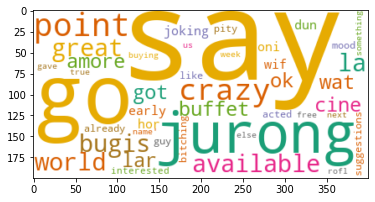

In [189]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(stopwords=english_stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

wc.generate(data_clean.texte["ham"])

plt.imshow(wc, interpolation="bilinear")

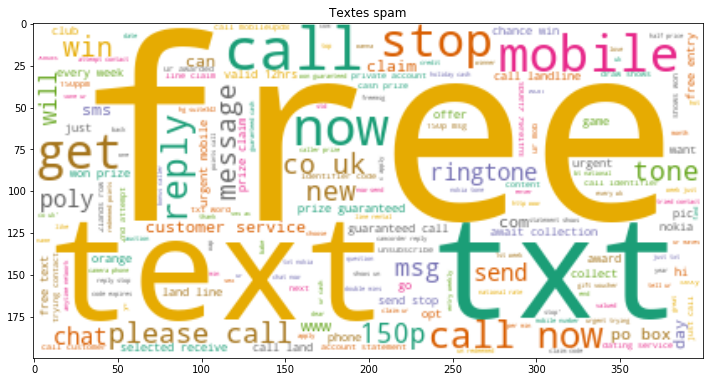

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(stopwords=english_stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

wc.generate(data_clean.texte["spam"])
plt.title("Textes spam")
plt.rcParams["figure.figsize"] = (12,12)

plt.imshow(wc, interpolation="bilinear")
plt.show()

- À partir de la matrice de termes réduite, entraînez un modèle de forêts aléatoires permettant de prédire si un texto est un spam ou non 

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = english_stop_words)

# On fit_transform 
cr_cv = cv.fit_transform(data.texte)
cr_dtm = pd.DataFrame(cr_cv.toarray(), columns = cv.get_feature_names())
cr_dtm.index = data.index
X = cr_dtm
X

/home/ivanka/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
y = data.labels
y

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: labels, Length: 5572, dtype: object

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0, test_size=0.2)
X_train.shape, y_train.shape


((4457, 8597), (4457,))

In [33]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [58]:
y_pred = rf.predict(X_test)

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         ham       1.00      0.97      0.99       979
        spam       0.84      0.99      0.91       136

    accuracy                           0.98      1115
   macro avg       0.92      0.98      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [57]:
# on affiche le score
rf.score(X_test, y_test)

0.9766816143497757

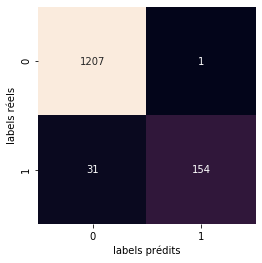

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('labels prédits')
plt.ylabel('labels réels');

- Essayez d'améliorer la prédiction de votre modèle en ajoutant une analyse en composantes principales en amont.

On peut imaginer que pour une entreprise qui développe cette solution, on souhaite plus à minimiser l'erreur consistant à définir comme spam un texto qui n'en est pas un (erreur de type 1, "faux positif") plutôt que de rater quelques spams : 
- Utilisez votre dernier modèle pour prédire des probabilités que le texto soit un spam. À partir de quelle valeur de cette probabilité notre modèle ne classe aucun non spam en spam?

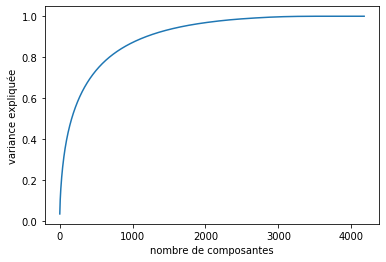

In [39]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('nombre de composantes')
plt.ylabel('variance expliquée')
plt.show()

In [63]:
pca = PCA(0.6).fit(X_train)
pca.n_components_

272

In [64]:
pca.explained_variance_ratio_.sum()

0.6002507093145786

In [65]:
X_pca = pca.transform(X_train)
projected_x_test = pca.transform(X_test)


In [77]:
# on transforme nos X train et X test
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Text(0.5, 1.0, 'Composantes principales')

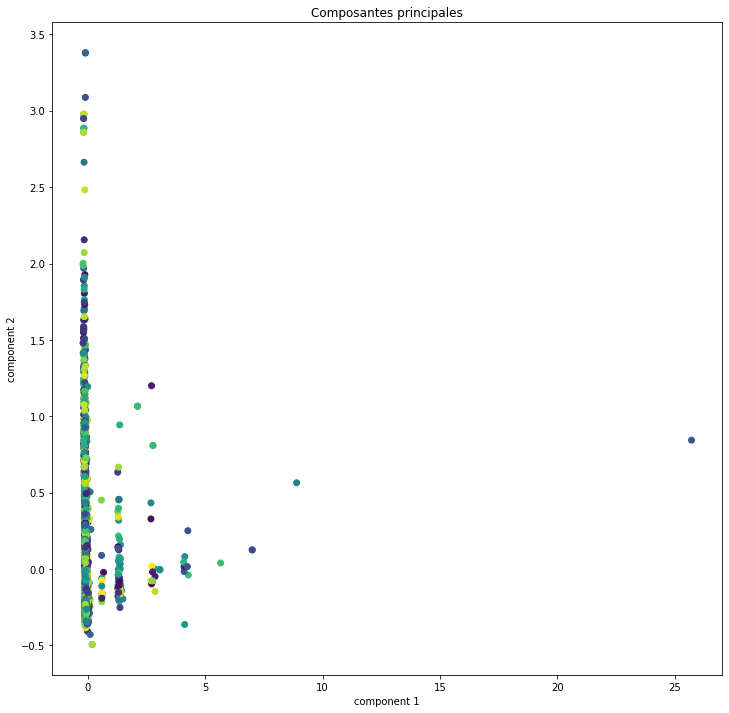

In [78]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=1, c = y_train.index)
#plt.axis('equal')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Composantes principales')

In [79]:
# On entraîne le modèle de randomforest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestClassifier()
rf.fit(X_train_pca, y_train)
# on affiche le score
rf.score(X_test_pca, y_test)

0.967713004484305

In [85]:
predictions = rf.predict_proba(X_test_pca)
predictions

array([[0.92, 0.08],
       [0.18, 0.82],
       [0.9 , 0.1 ],
       ...,
       [0.9 , 0.1 ],
       [0.08, 0.92],
       [1.  , 0.  ]])

In [81]:
# Le nombre d'erreurs de type 1 en fonction d'un seuil de décision se fixe ainsi :  
predictions = rf.predict_proba(X_test_pca)
y_pred = 1 * (predictions[:, 1] > 0.80)
erreur_type_1 = y_pred[y_test == 0].sum()
erreur_type_1

0

In [106]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr0, tpr0, thresholds0 = roc_curve(y_test, predictions[:, 1], pos_label=rf.classes_[1], 
                                    drop_intermediate=False)

In [107]:
tp = pd.DataFrame(dict(taux_faux_spams=fpr0, taux_vrais_spams=tpr0, threshold=thresholds0)).copy()
tp.drop(0, axis=0, inplace=True) #suppression du 1er seuil fixé arbitrairement à 2
tp

,taux_faux_spams,taux_vrais_spams,threshold
1,0.000000,0.02500,1.000000
2,0.000000,0.07500,0.990000
3,0.000000,0.10625,0.980000
4,0.000000,0.13750,0.970000
5,0.000000,0.17500,0.960000
...,...,...,...
113,0.609424,0.98750,0.001250
114,0.610471,0.98750,0.000909
115,0.615707,0.98750,0.000769
116,0.616754,0.98750,0.000714


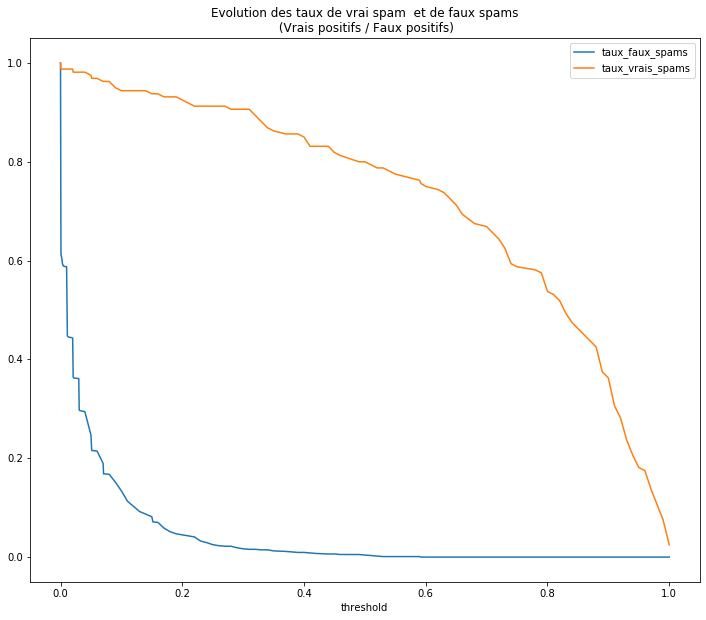

In [108]:
ax = tp.plot(x="threshold", y=['taux_faux_spams', 'taux_vrais_spams'], figsize=(12,10))
ax.set_title("Evolution des taux de vrai spam  et de faux spams\n (Vrais positifs / Faux positifs)");